# Learning from 1st solution of past JPX competition. LGBMRanker & Feature Engineering.


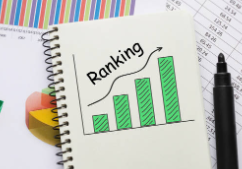


Thank you for your checking this notebook.

This is my baseline with LGBMRanker for "JPX Tokyo Stock Exchange Prediction" competition [(Link)](https://www.kaggle.com/competitions/jpx-tokyo-stock-exchange-prediction/overview). 

The reason why I use LGBMRanker is that 1st solution of past JPX competition also used it. You can see the informaiton about that solution in following link. Mr. M. Mochizuki, Thank you very much for sharing your solution! 

[SIGNATE: 日本取引所グループ ファンダメンタルズ分析チャレンジ](https://signate.jp/competitions/423)

[the 1st place solution of JPX Fundamentals Analysis Challenge on SIGNATE](https://speakerdeck.com/m_mochizuki/the-1st-place-solution-of-jpx-fundamentals-analysis-challenge-on-signate?slide=2)

If you think this notebook is useful, please give your comment or question and I appreciate your upvote as well. :) 

<a id='top'></a>
## Contents
1. [Import Library & Set Config](#config)
2. [Load Data](#load)
3. [Feature Engineering](#prep)
4. [Define & Train Model](#model)
5. [Prediction with API](#pred)
6. [Conclusion](#conclusion)
7. [Reference](#ref)

## Version History

Ver.12 - For final submission, concatenated "stock_prices.csv" under "supplemental_files".

<a id='config'></a>

---
# 1. Import Library & Set Config
---

[Back to Contents](#top)

In [ ]:
# === General ===
import sys, warnings, time, os, copy, gc, re, random
import pickle as pkl
warnings.filterwarnings('ignore')
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)
# pd.set_option("display.max_colwidth", 10000)
import seaborn as sns
sns.set()
from pandas.io.json import json_normalize
from pprint import pprint
from pathlib import Path
from tqdm import tqdm
tqdm.pandas()
from datetime import datetime, timedelta

# === Pre-processing ===
from sklearn.preprocessing import OrdinalEncoder

# === Model ===
from lightgbm import LGBMRanker

In [ ]:
# Configuration
DEBUG = False
PATH_INPUT = r'../input/jpx-tokyo-stock-exchange-prediction'

if DEBUG:
    TRAIN_PERIOD = ['2021.06.01', '2021.12.03']
else:
    TRAIN_PERIOD = ['2021.01.01', '2021.12.03']

<a id='load'></a>

---
# 2. Load Data

Below two file will be loaded.

../train_files/stock_prices.csv: Price info of stock covering the main training period.

../stock_list.csv: Mapping between the SecuritiesCode and company names, plus general information about which industry the company is in.

More detail is in [Data Description](https://www.kaggle.com/competitions/jpx-tokyo-stock-exchange-prediction/data)

---

[Back to Contents](#top)

In [ ]:
dfPriceTrain = pd.read_csv(PATH_INPUT + r'/train_files/stock_prices.csv', usecols=['Date', 'SecuritiesCode', 'Open', 'High', 'Low', 'Close', 'Volume', 'Target'])
dfPriceTrain['Date'] = pd.to_datetime(dfPriceTrain['Date'])
dfPriceTrain.set_index('Date', inplace=True)
dfPriceTrain = dfPriceTrain.loc[TRAIN_PERIOD[0]:TRAIN_PERIOD[1],:]
dfPriceTrain

In [ ]:
dfPriceSuppl = pd.read_csv(PATH_INPUT + r'/supplemental_files/stock_prices.csv', usecols=['Date', 'SecuritiesCode', 'Open', 'High', 'Low', 'Close', 'Volume', 'Target'])
dfPriceSuppl['Date'] = pd.to_datetime(dfPriceSuppl['Date'])
dfPriceSuppl.set_index('Date', inplace=True)
dfPriceSuppl

In [ ]:
dfPriceTrain = pd.concat([dfPriceTrain, dfPriceSuppl], axis=0)
dfPriceTrain

In [ ]:
dfList = pd.read_csv(PATH_INPUT + r'/stock_list.csv')
dfList

<a id='prep'></a>

---
# 3. Feature Engineering

The features of 1st place solution of past competition was based on technical and category of each stock. [(Link to the reference)](https://speakerdeck.com/m_mochizuki/the-1st-place-solution-of-jpx-fundamentals-analysis-challenge-on-signate?slide=2)

In this notebook, I try to implement below features of each stock.

- Market category
- 33 / 17 sector category
- Last 5/10/20 change rate of High and Low price
- Last 20/40/60/120 days change rate of close price
- Last 20/40/60/120 days deviation rate of close price and moving average.

---

[Back to Contents](#top)

In [ ]:
def add_lagCol(df, column, lag):
    dfTemp = pd.concat([df, df.groupby('SecuritiesCode')[column].shift(lag).add_prefix(f'shift{lag}_')], axis=1)
    return dfTemp

In [ ]:
def add_rollAvgCol(df, column, days):
    dfTemp = df.join(df.groupby('SecuritiesCode')[column].rolling(days).mean().add_prefix(f'rollavg{days}_').reset_index().set_index('level_1').drop('SecuritiesCode', axis=1))
    return dfTemp

In [ ]:
for i in [5, 10, 20, 40, 60, 120]:
    dfPriceTrain = add_lagCol(dfPriceTrain, ['High', 'Low', 'Close'], i)

dfPriceTrain = dfPriceTrain.reset_index()

for i in [20, 40, 60, 120]:
    dfPriceTrain = add_rollAvgCol(dfPriceTrain, ['High', 'Close'], i)

dfPriceTrain = dfPriceTrain.set_index('Date')

In [ ]:
# add features the last 5/10/20 change rate of High and Low price
for i in [5, 10, 20]:
    dfPriceTrain[f'change{i}_High'] = (dfPriceTrain['High'] - dfPriceTrain[f'shift{i}_High']) / dfPriceTrain[f'shift{i}_High']
    dfPriceTrain[f'change{i}_Low'] = (dfPriceTrain['Low'] - dfPriceTrain[f'shift{i}_Low']) / dfPriceTrain[f'shift{i}_Low']

# add features the last 20/40/60/120 days change rate of close price
for i in [20, 40, 60, 120]:
    dfPriceTrain[f'change{i}_Close'] = (dfPriceTrain['Close'] - dfPriceTrain[f'shift{i}_Close']) / dfPriceTrain[f'shift{i}_Close']

# add features the last 20/40/60/120 days deviation rate of close price and moving average.
for i in [20, 40, 60, 120]:
    dfPriceTrain[f'dev{i}_Close'] = (dfPriceTrain['Close'] - dfPriceTrain[f'rollavg{i}_Close']) / dfPriceTrain[f'rollavg{i}_Close']

In [ ]:
# add Market & Sector categories
listCate = ['SecuritiesCode', 'Section/Products', 'NewMarketSegment', '33SectorName', '17SectorName', 'NewIndexSeriesSize']
dfTrain = pd.merge(dfPriceTrain.reset_index(), dfList[listCate], on='SecuritiesCode', how='left')

In [ ]:
dfTrain[listCate] = dfTrain[listCate].fillna('noValue')

In [ ]:
ordEnc = OrdinalEncoder(
    handle_unknown = 'use_encoded_value', # 未知数をunknown valueに置き換える設定
    unknown_value = -2,
)

In [ ]:
listCate.remove('SecuritiesCode')
dfTrain[listCate] = pd.DataFrame(ordEnc.fit_transform(dfTrain[listCate]), columns=listCate)
pkl.dump(ordEnc, open('encoder.pkl', 'wb'))

In [ ]:
dfTrain

<a id='model'></a>

---
# 4. Define & Train Model

The 1st place solution of past competition used lightGBM's lanbdaRank. Mr. Mochizuki explained that the target of competition was NOT predicting price of stock itself. The target was predicting the rank of each stocks. So that means Learning-to-rank could be good to simplify the task. [(Link to the reference)](https://speakerdeck.com/m_mochizuki/the-1st-place-solution-of-jpx-fundamentals-analysis-challenge-on-signate?slide=2)

It is first time for me to use Learning-to-rank with LightGBM. So I refer the following notebook or web page mainly. Please upvote them as well!

- [LightGBM Ranker Introduction by BTURAN19](https://www.kaggle.com/code/bturan19/lightgbm-ranker-introduction/notebook) 
- [LGBMRankerを使ってAmazonのレビューデータセットでランク学習してみる](https://yolo-kiyoshi.com/2021/02/08/post-2606/)

---

[Back to Contents](#top)

In [ ]:
dfTrain['Target'] = dfTrain.groupby('Date')['Target'].rank('dense', ascending=True).fillna(0).astype(int)
dfTrain['Target'] = pd.qcut(dfTrain['Target'], 30).cat.codes  # Bigger number on Target is bigger value on original Target.

In [ ]:
if DEBUG:
    dfTrain = dfTrain.iloc[-20000: , :]

numTrain = int(dfTrain.shape[0] * 0.8)
dfVal = dfTrain.iloc[numTrain: , :]
dfTrain = dfTrain.iloc[:numTrain, :]

dfTrain = dfTrain.sort_values('SecuritiesCode')
dfVal = dfVal.sort_values('SecuritiesCode')

xTrain, yTrain = dfTrain.drop(['Date', 'SecuritiesCode', 'Target'], axis=1), dfTrain['Target']
xVal, yVal = dfVal.drop(['Date', 'SecuritiesCode', 'Target'], axis=1), dfVal['Target']

listQueryTrain = dfTrain['SecuritiesCode'].value_counts().to_list()
listQueryVal = dfVal['SecuritiesCode'].value_counts().to_list()

In [ ]:
model = LGBMRanker(boosting_type="dart", objective="lambdarank", n_estimators=5000, 
                   random_state=37, num_leaves=2**6-1, learning_rate=0.001, max_bin=128
                  )

In [ ]:
model.fit(xTrain, yTrain,
          group = listQueryTrain,
          verbose=100,
          early_stopping_rounds=200, 
          eval_set=[(xVal, yVal)],
          eval_group=[listQueryVal]
         )

In [ ]:
file = 'trained_model.pkl'
pkl.dump(model, open(file, 'wb'))

In [ ]:
# Feature Importance
plt.figure(figsize=(12, 15))
df_plt = pd.DataFrame({'feature_name': xTrain.columns, 'feature_importance': model.feature_importances_})
df_plt.sort_values('feature_importance', ascending=False, inplace=True)
sns.barplot(x="feature_importance", y="feature_name", data=df_plt)
plt.title('feature importance')

<a id='pred'></a>

---
# 5. Prediction with time-series API

- Following the explanation from the organizer [here](https://www.kaggle.com/competitions/jpx-tokyo-stock-exchange-prediction/overview/evaluation)
- As recommended in [this web page](https://logmi.jp/tech/articles/325898), using try and except to continue the prediction during the loop by API.
- My model is using past data as input but API gives me only one day data. So I need to prepare two data frame, one is about data before date which API gives and another one is to keep data which API gives during the loop.

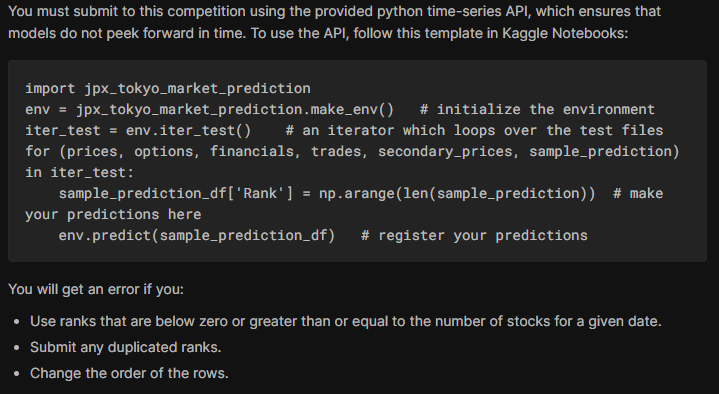


---

[Back to Contents](#top)

In [ ]:
import jpx_tokyo_market_prediction
env = jpx_tokyo_market_prediction.make_env()
iter_test = env.iter_test()

In [ ]:
count = 0
countExcept = 0

# Prepare dataframe with past data for prediction.
dfPrice = pd.read_csv(PATH_INPUT + r'/train_files/stock_prices.csv', usecols=['Date', 'SecuritiesCode', 'Open', 'High', 'Low', 'Close', 'Volume'])
dfPrice['Date'] = pd.to_datetime(dfPrice['Date'])
dfPrice.set_index('Date', inplace=True)
dfPrice = dfPrice.loc[TRAIN_PERIOD[0]:TRAIN_PERIOD[1],:]
dfPrice

In [ ]:
dfPriceSuppl = pd.read_csv(PATH_INPUT + r'/supplemental_files/stock_prices.csv', usecols=['Date', 'SecuritiesCode', 'Open', 'High', 'Low', 'Close', 'Volume'])
dfPriceSuppl['Date'] = pd.to_datetime(dfPriceSuppl['Date'])
dfPriceSuppl.set_index('Date', inplace=True)
dfPriceSuppl

In [ ]:
dfPrice = pd.concat([dfPrice, dfPriceSuppl], axis=0)
dfPrice

In [ ]:
def predict_rank(X, model, sample_prediction, listSC):
    '''Predict Target value and make a ranking. Return submittion df.'''
    
    Y = model.predict(X)
    dfY = pd.DataFrame(Y.reshape(-1, 1))
    dfSC = pd.DataFrame(listSC)
    dfTemp = pd.concat([dfSC, dfY], axis=1)
    dfTemp.columns = ['SecuritiesCode', 'prediction']
    dfTemp['Rank'] = dfTemp["prediction"].rank(ascending=False,method="first") -1
    dfTemp['Rank'] = dfTemp['Rank'].astype(int)
    dfTemp = dfTemp.drop('prediction', axis=1)
    sample_prediction = sample_prediction.drop('Rank', axis=1)
    dfSub = sample_prediction.merge(dfTemp, on='SecuritiesCode', how='left')

    assert dfSub.shape == (len(listSC), 3), "Shape of dfSub is not correct."
    return dfSub    

In [ ]:
for (prices, options, financials, trades, secondary_prices, sample_prediction) in iter_test:
    try:
        prices = prices[['Date', 'SecuritiesCode', 'Open', 'High', 'Low', 'Close', 'Volume']]
        prices['Date'] = pd.to_datetime(prices['Date'])
        prices.set_index('Date', inplace=True)
        
        dfPrice = pd.concat([dfPrice, prices], axis=0)
        dfPriceTrain = dfPrice.copy()
        
        for i in [5, 10, 20, 40, 60, 120]:
            dfPriceTrain = add_lagCol(dfPriceTrain, ['High', 'Low', 'Close'], i)
            
        dfPriceTrain = dfPriceTrain.reset_index()
        
        for i in [20, 40, 60, 120]:
            dfPriceTrain = add_rollAvgCol(dfPriceTrain, ['High', 'Close'], i)
            
        dfPriceTrain = dfPriceTrain.set_index('Date')
            
        # add features the last 5/10/20 change rate of High and Low price
        for i in [5, 10, 20]:
            dfPriceTrain[f'change{i}_High'] = (dfPriceTrain['High'] - dfPriceTrain[f'shift{i}_High']) / dfPriceTrain[f'shift{i}_High']
            dfPriceTrain[f'change{i}_Low'] = (dfPriceTrain['Low'] - dfPriceTrain[f'shift{i}_Low']) / dfPriceTrain[f'shift{i}_Low']
        
        # add features the last 20/40/60/120 days change rate of close price
        for i in [20, 40, 60, 120]:
            dfPriceTrain[f'change{i}_Close'] = (dfPriceTrain['Close'] - dfPriceTrain[f'shift{i}_Close']) / dfPriceTrain[f'shift{i}_Close']
        
        # add features the last 20/40/60/120 days deviation rate of close price and moving average.
        for i in [20, 40, 60, 120]:
            dfPriceTrain[f'dev{i}_Close'] = (dfPriceTrain['Close'] - dfPriceTrain[f'rollavg{i}_Close']) / dfPriceTrain[f'rollavg{i}_Close']
        
        # add Market & Sector categories
        listCate = ['SecuritiesCode', 'Section/Products', 'NewMarketSegment', '33SectorName', '17SectorName', 'NewIndexSeriesSize']
        dfTrain = pd.merge(dfPriceTrain.reset_index(), dfList[listCate], on='SecuritiesCode', how='left')
        dfTrain[listCate] = dfTrain[listCate].fillna('noValue')
        listCate.remove('SecuritiesCode')
        dfTrain[listCate] = pd.DataFrame(ordEnc.transform(dfTrain[listCate]), columns=listCate)
        
        if DEBUG:
            display(dfTrain)
        
        dfTrain = dfTrain.tail(2000)
        listSC = dfTrain['SecuritiesCode'].to_list()
        X = dfTrain.drop(['Date', 'SecuritiesCode'], axis=1)
        
        dfSub = predict_rank(X, model, sample_prediction, listSC)
        
        if DEBUG:
            display(dfSub)
            
        env.predict(dfSub)
        count += 1
              
    except:
        env.predict(sample_prediction)
        count += 1
        countExcept += 1

In [ ]:
print(f'Finished prediction. {countExcept} / {count} times exception occurred. \n')

<a id='conclusion'></a>

---
# 6. Conclusion


Thank you for your checking this notebook. If you find an interesting thing here, please click upvote :)

---

[Back to Contents](#top)

<a id='ref'></a>

---
# 7. Reference
1. [JPX_EDA_with_cudf_&_Key_Events_Japan_Market](https://www.kaggle.com/code/hechtjp/jpx-eda-with-cudf-key-events-japan-market?scriptVersionId=94993105)
2. [ポイントを押さえればTime-seriesコンペは怖くない
堅牢で速いコードを書くためのテクニックと心構え](https://logmi.jp/tech/articles/325898)
3. [the 1st place solution of JPX Fundamentals Analysis Challenge on SIGNATE](https://speakerdeck.com/m_mochizuki/the-1st-place-solution-of-jpx-fundamentals-analysis-challenge-on-signate?slide=2)
4. [LightGBM Ranker Introduction by BTURAN19](https://www.kaggle.com/code/bturan19/lightgbm-ranker-introduction/notebook)
5. [LGBMRankerを使ってAmazonのレビューデータセットでランク学習してみる](https://yolo-kiyoshi.com/2021/02/08/post-2606/)

---

[Back to Contents](#top)